# Scenario Forecasting Tool

This notebook is a supplement to the paper "Enhanced Conditional Forecasting with Temporal Fusion Transformer" consisting of an interactive scenario forecasting tool. The required user input is explained throughout the notebook.



## Install and Import required packages and libraries
Set directory to main directory!

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("/Users/yuanliu/Documents/Erasmus University/MSc Quantitive Marketing and Business Analytics/P3/Seminar Case Study/Data/case_studies_ah/")

In [3]:
import copy
from pathlib import Path
import warnings
import datetime

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

from sklearn.metrics import mean_absolute_percentage_error

plt.style.use('ggplot')

colors = plt.cm.Spectral(np.linspace(0,1,30))
plt.rcParams["figure.figsize"] = (20,5)

# Set Seeds
seed_no = 1
np.random.seed(seed_no)
torch.manual_seed(seed_no);

## Select Product Type
The choices are:
- MAIZE
- WHEAT
- SUNFLOWER OIL

In [25]:
product_type = "WHEAT"
date_filter = datetime.date(year = 2018, month = 1, day = 1)
date_end = datetime.date(year = 2022, month = 10, day = 1)

In [26]:
# load data from target commodity
if product_type == "WHEAT":
    trade_data = pd.read_csv("Data/wheat.csv")
    
if product_type == "MAIZE":
    trade_data = pd.read_csv("Data/maize_corn.csv")
    
if product_type == "SUNFLOWER OIL":
    trade_data = pd.read_csv("Data/sunflower_oil.csv")
    
# Add Time Period steps
trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})

# Make sure that the right product is isolated
products = trade_data["product"].drop_duplicates().to_list()

if product_type == 'SUNFLOWER OIL' or product_type == 'MAIZE':
    product_filter = products[0]

if product_type == 'WHEAT':
    product_filter = products[1]
        
# Add correct labels to the partner and declarent indices
    
partner_countries = pd.read_csv("Data/partners.csv", sep = ";")
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

# Dataframe for total trade data per month which we are forecasting
trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']
trade_data_total = trade_data_total[(trade_data_total["product"] == product_filter)]

trade_data_total = trade_data_total.set_index("TIME_PERIOD")
trade_data_total = trade_data_total[(trade_data_total.index >= date_filter)]

# Add 2 month rolling average for later validation
trade_data_total['MA2'] = trade_data_total["price"].rolling(window=2).mean()
trade_data_total['MA3'] = trade_data_total["price"].rolling(window=3).mean()

# Import other commodities and use same procedure
oil_data = pd.read_csv("Data/CMO-Historical-Data-Monthly.csv", header = 6)
oil_data = oil_data.rename(columns = {"Unnamed: 0" : "TIME_PERIOD"})
oil_data['TIME_PERIOD'] = oil_data['TIME_PERIOD'].str.replace(r'M', '-')
oil_data["TIME_PERIOD"] = pd.to_datetime(oil_data["TIME_PERIOD"], format = '%Y-%m').dt.date
to_replace = oil_data["SUNFLOWER_OIL"].iloc[0]
oil_data = oil_data.replace(to_replace, 0)
oil_data = oil_data.drop_duplicates()
oil_data = oil_data.set_index("TIME_PERIOD")
oil_data = oil_data[(oil_data.index >= date_filter) & (oil_data.index <= date_end)]

# Isolate Ukraine - Netherlands Import data for later use
Ukr_Data = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine') & (trade_data_pivot["product"] == product_filter) & (trade_data_pivot["TIME_PERIOD"] >= date_filter)][['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']]
Ukr_Data = Ukr_Data.set_index("TIME_PERIOD")
Ukr_Data = Ukr_Data.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "UKR_QUANTITY"})
trade_data_total['UKR_QUANTITY'] = Ukr_Data['UKR_QUANTITY']
trade_data_total = trade_data_total.fillna(0)

# Import NOAA weather data
weather_data = pd.read_csv("Data/global_temperature_data.csv")
weather_data = weather_data.rename(columns = {"yearmonth" : "TIME_PERIOD"})
weather_data["TIME_PERIOD"] = pd.to_datetime(weather_data["TIME_PERIOD"], format = '%Y%m').dt.date
weather_data = weather_data.set_index("TIME_PERIOD")
weather_data = weather_data[(weather_data.index >= date_filter) & (weather_data.index <= date_end)]

weather_ukr = weather_data[weather_data['weather_countryname'] == 'Ukraine']
weather_fr = weather_data[weather_data['weather_countryname'] == 'France']
weather_ger = weather_data[weather_data['weather_countryname'] == 'Germany']

# Merge data to one frame 
data = trade_data_total.merge(oil_data, on = 'TIME_PERIOD')
data = data[data.columns.drop(list(data.filter(regex='Unnamed')))]

data['UKRMA3'] = trade_data_total["UKR_QUANTITY"].rolling(window=3).mean()

data['avgTempUkr'] = weather_ukr["AVG_TAVG"] / 10
data['avgTempFr'] = weather_fr["AVG_TAVG"] / 10
data['avgTempGer'] = weather_ger["AVG_TAVG"] / 10


In [27]:
data['product'] = data['product'].astype(str)
data['timeidx'] = range(len(data))

data['year'] = pd.DatetimeIndex(data.index).year.astype(str).astype('category')
data['month'] = pd.DatetimeIndex(data.index).month.astype(str).astype('category')

test_split = datetime.date(year = 2021, month = 1, day = 1)
training_data = data[(data.index < test_split)]

# Add MA2 
data['NGAS_EUR_MA2'] = data["NGAS_EUR"].rolling(window=2).mean()
data['CRUDE_PETRO_MA2'] = data["CRUDE_PETRO"].rolling(window=2).mean()

In [28]:
max_prediction_length = 6
max_encoder_length = 18

# Set to len(data) - max_prediction_lenth if we want to assess in sample loss
training_cutoff = len(data)
target_feat = "price" #price, MA2

# For in sample validation, set to end of war (7) and control the forecast window with max_prediction_length
months_into_war = 7
months_to_drop = 7 - months_into_war

if months_to_drop == 0:
    reduced_data_set = data.copy()

else:
    reduced_data_set = data.head(- months_to_drop)
    
training = TimeSeriesDataSet(
    # SWITCHED FROM DATA
    reduced_data_set[lambda x: x.timeidx <= training_cutoff],
    time_idx="timeidx",
    target=target_feat,
    group_ids=["product"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["product"],
    static_reals=[],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals= [
        "timeidx", 
        "NGAS_EUR", 
        "CRUDE_PETRO", 
        "UKR_QUANTITY"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        target_feat,
        "OBS_VALUE_QUANTITY_TON",
        "OBS_VALUE_VALUE_1000EURO",
        "MAIZE",
        "WHEAT_US_HRW",
        "SUNFLOWER_OIL",
    ],
    target_normalizer=GroupNormalizer(
        # Earlier GroupNormalizer
        groups=["product"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(training, reduced_data_set, predict=True, stop_randomization=True)

# create seeded dataloaders in order to ensure reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_no)

batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, worker_init_fn=seed_worker,
    generator=g)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0, worker_init_fn=seed_worker,
    generator=g)


In [29]:
# Set hyperparameters found from optimizing conditional forecast of final 2 months

if product_type == "WHEAT":
    res = [0.756836784, 80, 0.206806068, 49, 2, 0.071267492]
    
if product_type == "MAIZE":
    res = [0.464546909, 46, 0.184018151, 18, 3, 0.019534113]
    
if product_type == "SUNFLOWER OIL":
    res = [0.379754699, 118, 0.14986229, 61, 4, 0.082224116]
                             
gradient_clip_val = res[0]
hidden_size = res[1]
dropout = res[2]
hidden_continuous_size = res[3]
attention_head_size = res[4]
learning_rate = res[5]

In [30]:
# Define modeltypes and fill with pre-trained data
model_seed0 = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

model_seed1 = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

model_seed2 = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

model_seed3 = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

model_seed4 = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

model_seed5 = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

model_seed6 = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

model_seed7 = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

if product_type == 'SUNFLOWER OIL':
    model_seed0.load_state_dict(torch.load('Pre-Trained_Models/sunfloweroil_seed0.pth'))
    model_seed1.load_state_dict(torch.load('Pre-Trained_Models/sunfloweroil_seed1.pth'))
    model_seed2.load_state_dict(torch.load('Pre-Trained_Models/sunfloweroil_seed2.pth'))
    model_seed3.load_state_dict(torch.load('Pre-Trained_Models/sunfloweroil_seed3.pth'))
    model_seed4.load_state_dict(torch.load('Pre-Trained_Models/sunfloweroil_seed4.pth'))
    model_seed5.load_state_dict(torch.load('Pre-Trained_Models/sunfloweroil_seed5.pth'))
    model_seed6.load_state_dict(torch.load('Pre-Trained_Models/sunfloweroil_seed6.pth'))
    model_seed7.load_state_dict(torch.load('Pre-Trained_Models/sunfloweroil_seed7.pth'));

if product_type == 'WHEAT':
    model_seed0.load_state_dict(torch.load('Pre-Trained_Models/wheat_seed0.pth'))
    model_seed1.load_state_dict(torch.load('Pre-Trained_Models/wheat_seed1.pth'))
    model_seed2.load_state_dict(torch.load('Pre-Trained_Models/wheat_seed2.pth'))
    model_seed3.load_state_dict(torch.load('Pre-Trained_Models/wheat_seed3.pth'))
    model_seed4.load_state_dict(torch.load('Pre-Trained_Models/wheat_seed4.pth'))
    model_seed5.load_state_dict(torch.load('Pre-Trained_Models/wheat_seed5.pth'))
    model_seed6.load_state_dict(torch.load('Pre-Trained_Models/wheat_seed6.pth'))
    model_seed7.load_state_dict(torch.load('Pre-Trained_Models/wheat_seed7.pth'));
    
if product_type == "MAIZE":
    model_seed0.load_state_dict(torch.load('Pre-Trained_Models/maize_seed0.pth'))
    model_seed1.load_state_dict(torch.load('Pre-Trained_Models/maize_seed1.pth'))
    model_seed2.load_state_dict(torch.load('Pre-Trained_Models/maize_seed2.pth'))
    model_seed3.load_state_dict(torch.load('Pre-Trained_Models/maize_seed3.pth'))
    model_seed4.load_state_dict(torch.load('Pre-Trained_Models/maize_seed4.pth'))
    model_seed5.load_state_dict(torch.load('Pre-Trained_Models/maize_seed5.pth'))
    model_seed6.load_state_dict(torch.load('Pre-Trained_Models/maize_seed6.pth'))
    model_seed7.load_state_dict(torch.load('Pre-Trained_Models/maize_seed7.pth'));

In [31]:
def situation_simulator(energyPrices, tradingIntensity):
    last_data = data[lambda x: x.timeidx == (x.timeidx.max())]
    lastGas = last_data["NGAS_EUR"].item()
    lastOil = last_data["CRUDE_PETRO"].item()
    lastQuant = last_data["UKR_QUANTITY"].item()
    
    max_quantity = data[(data.index >= datetime.date(year = 2020, month = 2, day = 1)) & (data.index <= datetime.date(year = 2022, month = 2, day = 1))]["UKR_QUANTITY"].mean()
    max_GasPrice = data["NGAS_EUR"].max()
    max_OilPrice = data["CRUDE_PETRO"].max()
    
    very_high_peak_trade = max_quantity * 2
    high_peak_trade = max_quantity * 1.5
    moderate_peak_trade = max_quantity * 1
    
    very_high_peak_gas = max_GasPrice * 1.5
    high_peak_gas = max_GasPrice * 0.75
    moderate_peak_gas = max_GasPrice * 0.5
    low_peak_gas = max_GasPrice * 0.2
    
    very_high_peak_oil = max_OilPrice * 1.5
    high_peak_oil = max_OilPrice * 0.75
    moderate_peak_oil = max_OilPrice * 0.5
    low_peak_oil = max_OilPrice * 0.2

    if tradingIntensity == "Low":
        simDataTrade = [0] * max_prediction_length
    
    if tradingIntensity == "Moderate":
        difTrade = moderate_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [moderate_peak_trade] * (max_prediction_length - 1)

    if tradingIntensity == "High":
        difTrade = high_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [high_peak_trade] * (max_prediction_length - 1)

    if tradingIntensity == "Very High":
        difTrade = very_high_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [very_high_peak_trade] * (max_prediction_length - 1)
    
        
    if energyPrices == "Low":
        difGas = low_peak_gas - lastGas
        difOil = low_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [low_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [low_peak_oil] * (max_prediction_length - 1)
    
    if energyPrices == "Moderate":
        difGas = moderate_peak_gas - lastGas
        difOil = moderate_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [moderate_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [moderate_peak_oil] * (max_prediction_length - 1)

    if energyPrices == "High":
        difGas = high_peak_gas - lastGas
        difOil = high_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [high_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [high_peak_oil] * (max_prediction_length - 1)

    if energyPrices == "Very High":
        difGas = very_high_peak_gas - lastGas
        difOil = very_high_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [very_high_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [very_high_peak_oil] * (max_prediction_length - 1)
            
    return simDataGas, simDataOil, simDataTrade    
    

In [32]:
simDataGas, simDataOil, simDataTrade = situation_simulator("Very High", "Low")

encoder_data = data[lambda x: x.timeidx > x.timeidx.max() - max_encoder_length]
last_data = data[lambda x: x.timeidx == x.timeidx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.index + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

decoder_data["timeidx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["timeidx"] += encoder_data["timeidx"].max() + 1 - decoder_data["timeidx"].min()\

decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings
decoder_data["year"] = decoder_data.date.dt.year.astype(str).astype("category")  # categories have be strings

for i in range(max_prediction_length):
    replaceIndex = i
    
    replaceValueGas = simDataGas[replaceIndex]
    replaceValueOil = simDataOil[replaceIndex]
        
    decoder_data.loc[replaceIndex,'NGAS_EUR'] = replaceValueGas
    decoder_data.loc[replaceIndex,'CRUDE_PETRO'] = replaceValueOil

# # combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

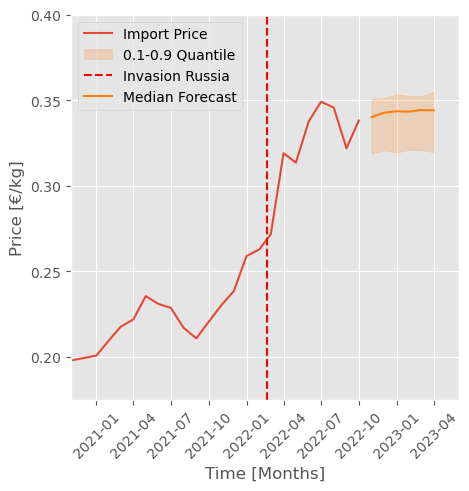

In [33]:
model_seed0.eval()
model_seed1.eval()
model_seed2.eval()
model_seed3.eval()
model_seed4.eval()
model_seed5.eval()
model_seed6.eval()
model_seed7.eval()

new_raw_predictions_seed0, new_x_seed0 = model_seed0.predict(new_prediction_data, mode="raw", return_x=True)
new_raw_predictions_seed1, new_x_seed1 = model_seed1.predict(new_prediction_data, mode="raw", return_x=True)
new_raw_predictions_seed2, new_x_seed2 = model_seed2.predict(new_prediction_data, mode="raw", return_x=True)
new_raw_predictions_seed3, new_x_seed3 = model_seed3.predict(new_prediction_data, mode="raw", return_x=True)
new_raw_predictions_seed4, new_x_seed4 = model_seed4.predict(new_prediction_data, mode="raw", return_x=True)
new_raw_predictions_seed5, new_x_seed5 = model_seed5.predict(new_prediction_data, mode="raw", return_x=True)
new_raw_predictions_seed6, new_x_seed6 = model_seed6.predict(new_prediction_data, mode="raw", return_x=True)
new_raw_predictions_seed7, new_x_seed7 = model_seed7.predict(new_prediction_data, mode="raw", return_x=True)

combined_predictions = [new_raw_predictions_seed0['prediction'], 
                        new_raw_predictions_seed1['prediction'], 
                        new_raw_predictions_seed2['prediction'],
                        new_raw_predictions_seed3['prediction'],
                        new_raw_predictions_seed4['prediction'], 
                        new_raw_predictions_seed5['prediction'],
                        new_raw_predictions_seed6['prediction'],
                        new_raw_predictions_seed7['prediction']
                       ]

def sim_forecaster_plotter(raw_predictions_combined, data, prediction_length):
    q02, q10, q25, q5, q75, q90, q98 = [], [], [], [], [], [], []
    
    for raw_predictions in raw_predictions_combined:
        q02.append([])
        q10.append([])
        q25.append([])
        q5.append([])
        q75.append([])
        q90.append([])
        q98.append([])

        for i in range(len(raw_predictions[0])):
            q02[-1].append(sorted(raw_predictions[0][i])[0].item())
            q10[-1].append(sorted(raw_predictions[0][i])[1].item())
            q25[-1].append(sorted(raw_predictions[0][i])[2].item())
            q5[-1].append(sorted(raw_predictions[0][i])[3].item())
            q75[-1].append(sorted(raw_predictions[0][i])[4].item())
            q90[-1].append(sorted(raw_predictions[0][i])[5].item())
            q98[-1].append(sorted(raw_predictions[0][i])[6].item())
        
    q02 = np.array([q02[0], q02[1], q02[2], q02[3], q02[4], q02[5], q02[6], q02[7]]).mean(axis=0)
    q10 = np.array([q10[0], q10[1], q10[2], q10[3], q10[4], q10[5], q10[6], q10[7]]).mean(axis=0)
    q25 = np.array([q25[0], q25[1], q25[2], q25[3], q25[4], q25[5], q25[6], q25[7]]).mean(axis=0)
    q5 = np.array([q5[0], q5[1], q5[2], q5[3], q5[4], q5[5], q5[6], q5[7]]).mean(axis=0)
    q75 = np.array([q75[0], q75[1], q75[2], q75[3], q75[4], q75[5], q75[6], q75[7]]).mean(axis=0)
    q90 = np.array([q90[0], q90[1], q90[2], q90[3], q90[4], q90[5], q90[6], q90[7]]).mean(axis=0)
    q98 = np.array([q98[0], q98[1], q98[2], q98[3], q98[4], q98[5], q98[6], q98[7]]).mean(axis=0)
                
    data_plotter = data.copy()
    data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - prediction_length)
    
    last_data = data[lambda x: x.timeidx == x.timeidx.max()]
    
    first_month  = int(last_data["month"]) + 1 - months_to_drop
    first_year = int(last_data["year"])
    
    index_list = list(data_plotter.index.values)
    
    used_list_new = []
    
    for i in range(prediction_length):
        current_month = first_month + i
        current_year = first_year
        
        if current_month > 12:
            current_month = current_month - 12
            current_year = first_year + 1
        
        used_list_new.append(datetime.date(year = current_year, month = current_month, day = 1))
            
    used_list = index_list[-max_prediction_length:]
    
    ax = data_plotter[(data_plotter.index > date_filter)][[target_feat]].plot(label = 'Actual Price')
    plt.fill_between(used_list_new, q10, q90, alpha = 0.2, color = 'tab:orange')

    plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Invasion Russia')
    plt.xlim([datetime.date(2020, 11, 1), datetime.date(2023, 6, 1)]);
    plt.xticks(rotation = 45)
    plt.plot(used_list_new, q5, color = 'tab:orange', label = 'Median Forecast')
    
    if product_type == "SUNFLOWER OIL":
        plt.ylim(0.6, 1.9)
        
    if product_type == 'MAIZE':
        plt.ylim(0.15, 0.45)
        
    if product_type == "WHEAT":
        plt.ylim(0.175, 0.4)
    plt.xlabel('Time [Months]')
    plt.ylabel('Price [€/kg]')
    plt.legend(['Import Price','0.1-0.9 Quantile', 'Invasion Russia', 'Median Forecast'], loc = 'upper left')
    
sim_forecaster_plotter(combined_predictions, data, max_prediction_length)   

In [34]:
plt.rcParams["figure.figsize"] = (5,5)

@widgets.interact(
    energyPrices=['Low', 'Moderate', 'High', 'Very High'], 
    tradingIntensity = ['Low', 'Moderate', 'High', 'Very High'])
def plotter(energyPrices, tradingIntensity):
    simDataGas, simDataOil, simDataTrade = situation_simulator(energyPrices, tradingIntensity)

    encoder_data = data[lambda x: x.timeidx > x.timeidx.max() - max_encoder_length]

    # select last known data point and create decoder data from it by repeating it and incrementing the month
    # in a real world dataset, we should not just forward fill the covariates but specify them to account
    # for changes in special days and prices (which you absolutely should do but we are too lazy here)
    last_data = data[lambda x: x.timeidx == x.timeidx.max()]
    decoder_data = pd.concat(
        [last_data.assign(date=lambda x: x.index + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
        ignore_index=True,
    )

    # add time index consistent with "data"
    decoder_data["timeidx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
    decoder_data["timeidx"] += encoder_data["timeidx"].max() + 1 - decoder_data["timeidx"].min()

    # adjust additional time feature(s)
    decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings
    decoder_data["year"] = decoder_data.date.dt.year.astype(str).astype("category")  # categories have be strings

    for i in range(max_prediction_length):
        replaceIndex = i

        replaceValueGas = simDataGas[replaceIndex]
        replaceValueOil = simDataOil[replaceIndex]
        replaceValueTrade = simDataTrade[replaceIndex]
        
        if target_feat == "price":
            replaceGas = "NGAS_EUR"
            replaceOil = "CRUDE_PETRO"
        
        if target_feat == "MA2":
            replaceGas = "NGAS_EUR_MA2"
            replaceOil = "CRUDE_PETRO_MA2"

        decoder_data.loc[replaceIndex, replaceGas] = replaceValueGas
        decoder_data.loc[replaceIndex, replaceOil] = replaceValueOil
        decoder_data.loc[replaceIndex, 'UKR_QUANTITY'] = replaceValueTrade
        
    # combine encoder and decoder data
    new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
    
    new_raw_predictions_seed0, new_x_seed0 = model_seed0.predict(new_prediction_data, mode="raw", return_x=True)
    new_raw_predictions_seed1, new_x_seed1 = model_seed1.predict(new_prediction_data, mode="raw", return_x=True)
    new_raw_predictions_seed2, new_x_seed2 = model_seed2.predict(new_prediction_data, mode="raw", return_x=True)
    new_raw_predictions_seed3, new_x_seed3 = model_seed3.predict(new_prediction_data, mode="raw", return_x=True)
    new_raw_predictions_seed4, new_x_seed4 = model_seed4.predict(new_prediction_data, mode="raw", return_x=True)
    new_raw_predictions_seed5, new_x_seed5 = model_seed5.predict(new_prediction_data, mode="raw", return_x=True)
    new_raw_predictions_seed6, new_x_seed6 = model_seed6.predict(new_prediction_data, mode="raw", return_x=True)
    new_raw_predictions_seed7, new_x_seed7 = model_seed7.predict(new_prediction_data, mode="raw", return_x=True)

    combined_predictions = [new_raw_predictions_seed0['prediction'], 
                            new_raw_predictions_seed1['prediction'], 
                            new_raw_predictions_seed2['prediction'], 
                            new_raw_predictions_seed3['prediction'], 
                            new_raw_predictions_seed4['prediction'], 
                            new_raw_predictions_seed5['prediction'], 
                            new_raw_predictions_seed6['prediction'], 
                            new_raw_predictions_seed7['prediction']]
    
    sim_forecaster_plotter(combined_predictions, data, max_prediction_length)       

interactive(children=(Dropdown(description='energyPrices', options=('Low', 'Moderate', 'High', 'Very High'), v…